# AQI Prediction

We will be using the below AQI scale from Open Weather since we are using the data collected from Open Weather API.

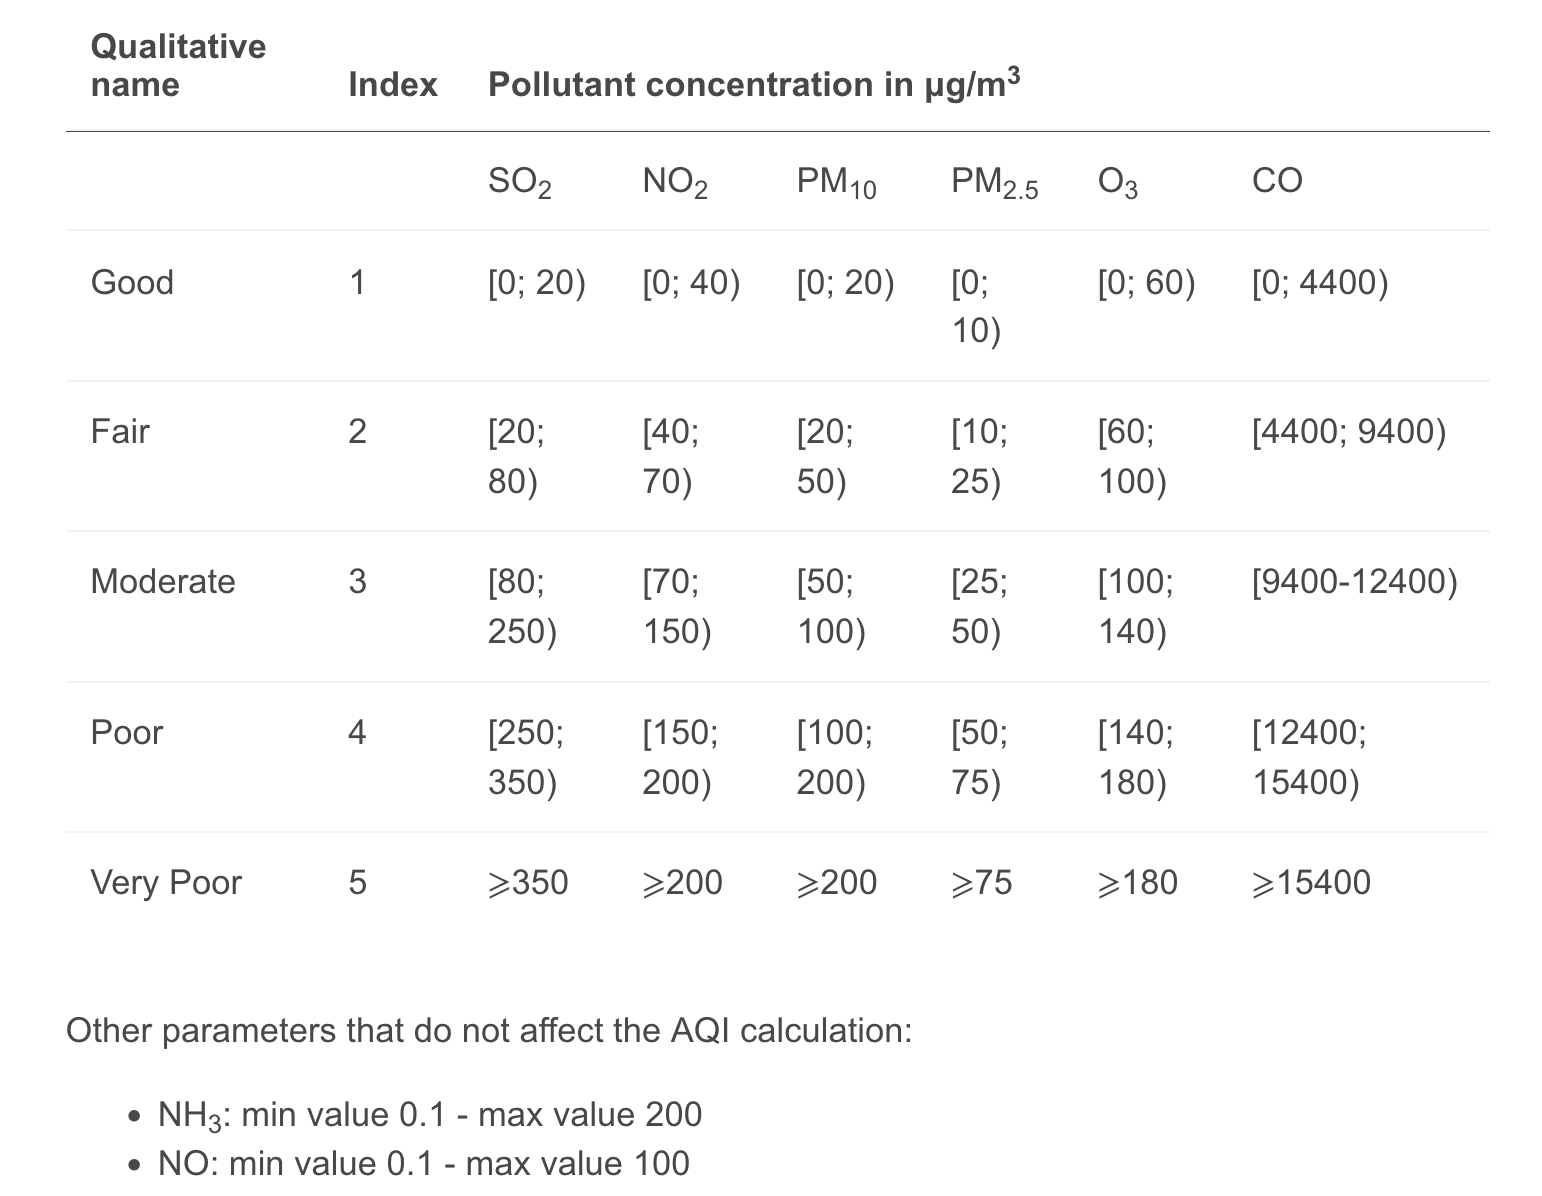

# Setup

In [37]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False


# Read CSV File

In [38]:
import pandas as pd

cm_df = pd.read_csv('/content/drive/MyDrive/air-quality-prediction/chaingmai-air-quality-v1.csv')
cm_df['datetime'] = pd.to_datetime(cm_df['datetime'], format='%d-%m-%Y %H:%M:%S')
cm_df = cm_df.sort_values(by='datetime')
cm_df.head()

,datetime,city,aqi,co,no,no2,so2,o3,pm2_5,pm10,nh3
0,2020-11-25 08:00:00,Chaing Mai,4,4005.43,74.21,13.54,12.99,0.58,46.81,56.77,11.27
1,2020-11-25 09:00:00,Chaing Mai,5,6462.10,114.44,30.16,13.59,2.84,61.17,72.29,8.36
2,2020-11-25 10:00:00,Chaing Mai,5,7583.62,84.04,93.22,12.64,20.21,74.19,84.86,8.23
3,2020-11-25 11:00:00,Chaing Mai,4,1428.60,2.52,23.99,10.97,128.75,36.00,39.85,7.92
4,2020-11-25 12:00:00,Chaing Mai,4,1068.12,0.92,11.82,9.30,164.51,36.59,39.49,6.40


# Data Exploration

In [39]:
cm_df.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
datetime,32547,2022-10-11 11:49:13.931237632,2020-11-25 08:00:00,2021-10-31 08:30:00,2022-10-09 09:00:00,2023-09-20 09:30:00,2024-08-30 10:00:00,NaN
aqi,32547.0,3.934341,1.0,3.0,4.0,5.0,5.0,1.173206
co,32547.0,3358.912808,320.43,1628.88,2777.1,4539.49,15808.11,2224.44623
no,32547.0,21.421681,0.0,1.05,8.83,31.74,228.88,28.54241
no2,32547.0,42.541393,-9999.0,16.62,29.82,54.15,329.02,88.401725
so2,32547.0,15.290053,1.8,8.11,12.64,19.55,87.74,10.073786
o3,32547.0,50.151033,-9999.0,0.01,1.43,65.8,755.31,105.589116
pm2_5,32547.0,62.162352,1.47,30.25,51.49,81.025,420.41,45.994096
pm10,32547.0,68.485699,-9999.0,34.845,58.29,89.56,433.95,73.707084
nh3,32547.0,14.15341,0.0,7.03,11.4,19.51,63.33,9.24666


In [40]:
cm_df.isna().sum()

,0
datetime,0
city,0
aqi,0
co,0
no,0
no2,0
so2,0
o3,0
pm2_5,0
pm10,0


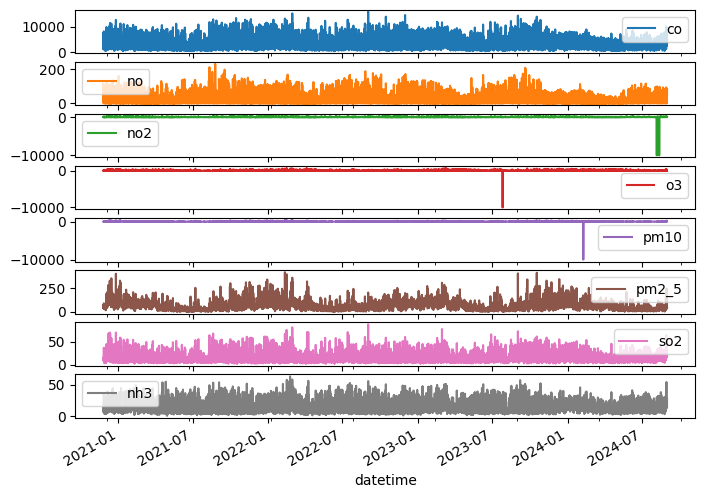

In [24]:
datetime = pd.to_datetime(cm_df['datetime'], format='%d-%m-%Y %H:%M:%S')

plot_cols = ['co', 'no', 'no2', 'o3', 'pm10', 'pm2_5', 'so2', 'nh3']
plot_features = cm_df[plot_cols]
plot_features.index = datetime
_ = plot_features.plot(subplots=True)

# Findings
From exploring these data, we can see that no2, o3 and pm10 has -9999 data which is impossible to have negative values.

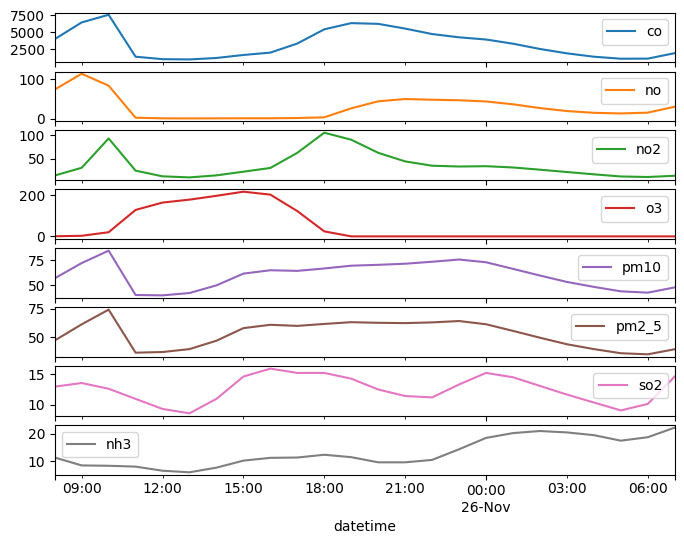

In [ ]:
plot_features = cm_df[plot_cols][:24]
plot_features.index = datetime[:24]
_ = plot_features.plot(subplots=True)

Remove the -9999 data points

In [41]:
cm_df.loc[cm_df['o3'] == -9999.0, 'o3'] = 0.0

cm_df.loc[cm_df['pm10'] == -9999.0, 'pm10'] = 0.0

cm_df.loc[cm_df['no2'] == -9999.0, 'no2'] = 0.0

# The above inplace edits are reflected in the DataFrame.
print(cm_df['o3'].min())
print(cm_df['pm10'].min())
print(cm_df['no2'].min())

0.0
0.0
0.0


In [26]:
df = cm_df.drop(columns=['datetime', 'city'])
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(color='#f1f1f1')  # Color NaNs grey
 .format(precision=2))

,aqi,co,no,no2,so2,o3,pm2_5,pm10,nh3
aqi,nan,nan,nan,nan,nan,nan,nan,nan,nan
co,0.49,nan,nan,nan,nan,nan,nan,nan,nan
no,0.15,0.47,nan,nan,nan,nan,nan,nan,nan
no2,0.36,0.82,-0.01,nan,nan,nan,nan,nan,nan
so2,0.44,0.78,0.22,0.76,nan,nan,nan,nan,nan
o3,0.25,-0.02,-0.38,-0.02,0.27,nan,nan,nan,nan
pm2_5,0.69,0.65,-0.02,0.60,0.68,0.39,nan,nan,nan
pm10,0.70,0.65,-0.01,0.60,0.67,0.38,1.00,nan,nan
nh3,0.39,0.63,0.36,0.58,0.80,-0.02,0.48,0.50,nan


# Remove the target aqi index from the independent variables

In [42]:
date_time = pd.to_datetime(cm_df.pop('datetime'), format='%Y-%m-%d %H:%M:%S')

In [43]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

In [44]:
day = 24*60*60
year = (365.2425)*day

cm_df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
cm_df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
cm_df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
cm_df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

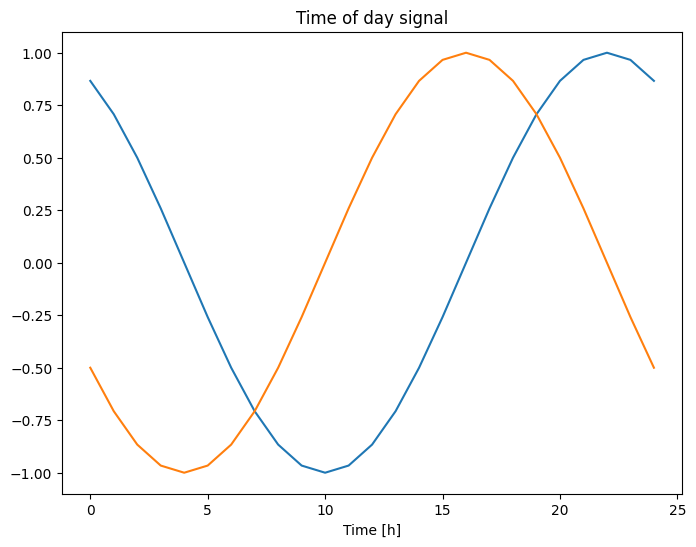

In [ ]:
plt.plot(np.array(cm_df['Day sin'])[:25])
plt.plot(np.array(cm_df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [45]:
y = cm_df['aqi']
cm_df = cm_df.drop(columns=['aqi', 'city'])
cm_df.head(5)

,co,no,no2,so2,o3,pm2_5,pm10,nh3,Day sin,Day cos,Year sin,Year cos
0,4005.43,74.21,13.54,12.99,0.58,46.81,56.77,11.27,8.660254e-01,-0.500000,-0.580944,0.813944
1,6462.10,114.44,30.16,13.59,2.84,61.17,72.29,8.36,7.071068e-01,-0.707107,-0.580360,0.814360
2,7583.62,84.04,93.22,12.64,20.21,74.19,84.86,8.23,5.000000e-01,-0.866025,-0.579776,0.814776
3,1428.60,2.52,23.99,10.97,128.75,36.00,39.85,7.92,2.588190e-01,-0.965926,-0.579192,0.815191
4,1068.12,0.92,11.82,9.30,164.51,36.59,39.49,6.40,1.011360e-11,-1.000000,-0.578608,0.815606


# Preprocess the data

In [46]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(cm_df)

# Create Data Windows

In [47]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length), 1:])
        y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(y)

In [48]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

scaled_data = np.column_stack((y.values, X_scaled))

sequence_length = 12
X, y = create_sequences(scaled_data, sequence_length)
y = to_categorical(y - 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

num_classes = y.shape[1]

model = Sequential([
    LSTM(64, activation='relu', input_shape=(X.shape[1], X.shape[2]), return_sequences=True),
    LSTM(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1, callbacks=callbacks)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


732/732 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.5680 - loss: 0.9832 - val_accuracy: 0.7053 - val_loss: 0.6316
Epoch 2/100
732/732 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.7235 - loss: 0.6057 - val_accuracy: 0.7285 - val_loss: 0.5970
Epoch 3/100
732/732 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.7403 - loss: 0.5686 - val_accuracy: 0.7471 - val_loss: 0.5556
Epoch 4/100
732/732 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.7590 - loss: 0.5428 - val_accuracy: 0.7606 - val_loss: 0.5328
Epoch 5/100
732/732 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.7688 - loss: 0.5159 - val_accuracy: 0.7620 - val_loss: 0.5229
Epoch 6/100
732/732 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.7742 - loss: 0.5090 - val_accuracy: 0.7806 - val_loss: 0.4959
Epoch 7/100
732/732 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.7872 - loss: 0.4806 - val_accuracy: 0.7885 - val_loss: 0.4852
Epoch 8/100
732/732 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.8020 - loss: 0.4602 - val_a

In [49]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

Test Loss: 0.42550668120384216, Test Accuracy: 0.8239090442657471


In [50]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1) + 1  # Add 1 to convert back to 1-5 range
actual_classes = np.argmax(y_test, axis=1) + 1

print(classification_report(actual_classes, predicted_classes))

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
              precision    recall  f1-score   support

           1       0.92      0.69      0.79       123
           2       0.79      0.76      0.78       370
           3       0.71      0.67      0.69       524
           4       0.75      0.75      0.75       827
           5       0.91      0.95      0.93      1410

    accuracy                           0.82      3254
   macro avg       0.82      0.77      0.79      3254
weighted avg       0.82      0.82      0.82      3254



In [ ]:
actual_classes[:5]

array([2, 4, 3, 5, 4])

In [52]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(actual_classes, predicted_classes)

<Figure size 1000x800 with 0 Axes>

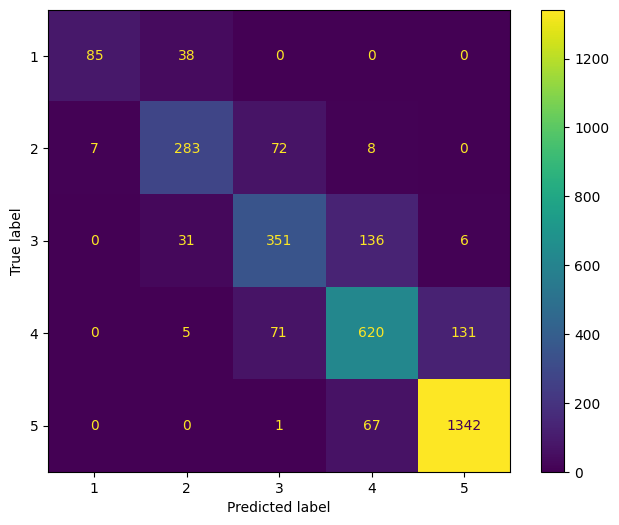

In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2, 3, 4, 5])
disp.plot()
plt.show()

In [ ]:
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1) + 1  # Add 1 to convert back to 1-5 range
actual_classes = np.argmax(y_test, axis=1) + 1

# Print some results
for i in range(10):
    print(f'Predicted AQI: {predicted_classes[i]}, Actual AQI: {actual_classes[i]}')

204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Predicted AQI: 2, Actual AQI: 2
Predicted AQI: 4, Actual AQI: 4
Predicted AQI: 5, Actual AQI: 5
Predicted AQI: 3, Actual AQI: 3
Predicted AQI: 2, Actual AQI: 2
Predicted AQI: 5, Actual AQI: 5
Predicted AQI: 3, Actual AQI: 3
Predicted AQI: 5, Actual AQI: 5
Predicted AQI: 3, Actual AQI: 3
Predicted AQI: 5, Actual AQI: 5


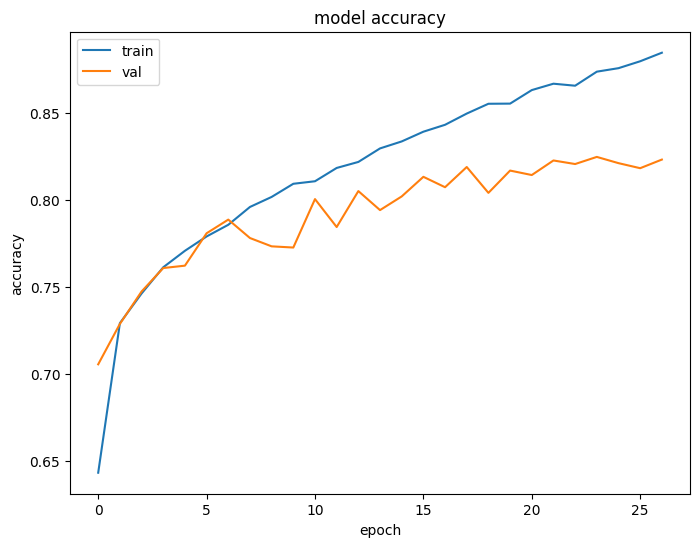

In [54]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

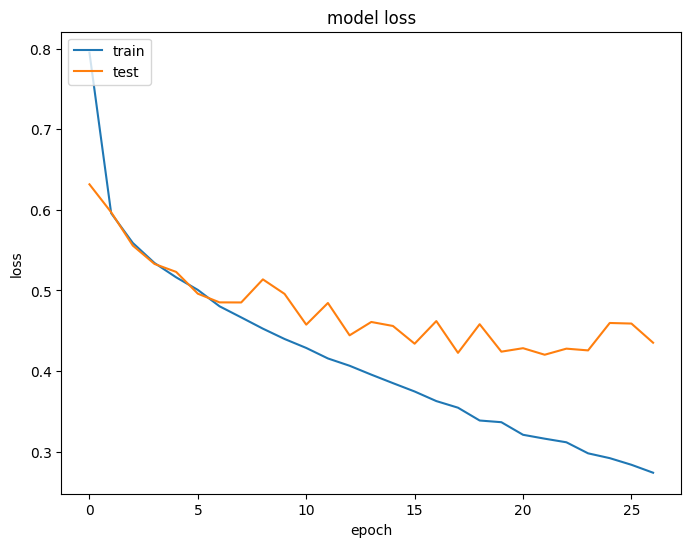

In [55]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save('cm_lstm_best_accuracy_aqi_v1.keras')

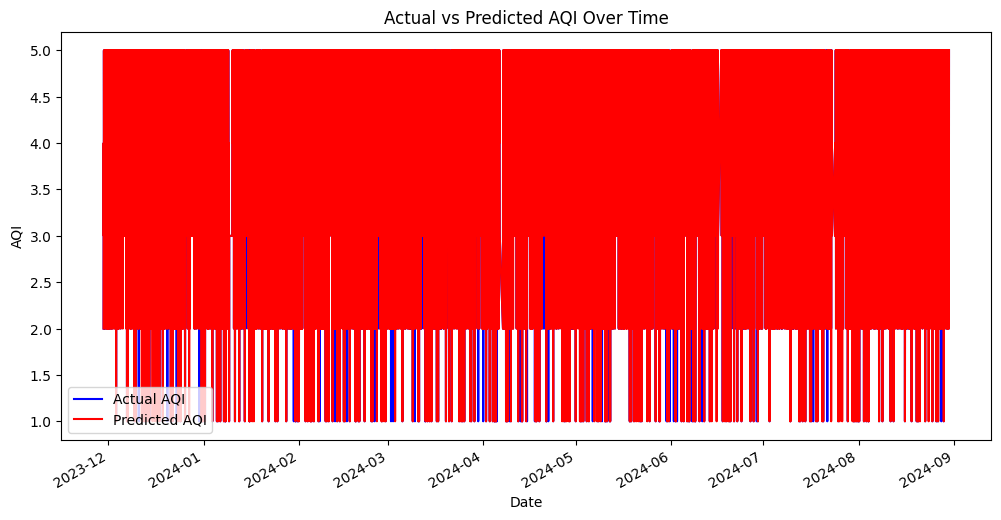

In [ ]:
results_df = pd.DataFrame({
    'datetime': datetime.iloc[-len(actual_classes):].values,
    'city': 'Chaing Mai',
    'true_aqi': actual_classes,
    'predicted_aqi': predicted_classes
})

results_df = results_df.sort_values('datetime')

plt.figure(figsize=(12, 6))
plt.plot(results_df['datetime'], results_df['true_aqi'], label='Actual AQI', color='blue')
plt.plot(results_df['datetime'], results_df['predicted_aqi'], label='Predicted AQI', color='red')

plt.title('Actual vs Predicted AQI Over Time')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()

plt.gcf().autofmt_xdate()

plt.show()

In [ ]:
results_df.to_csv('lstm_cm_data.csv')